<a href="https://colab.research.google.com/github/dhruvdcoder/HyperA/blob/master/Baseline/baseline_lstm_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torchtext import data,datasets

In [0]:
device = torch.device("cuda:0")

In [0]:
inputs = data.Field(tokenize='spacy')
answers = data.Field(sequential=False)

In [8]:
train, dev, test = datasets.MultiNLI.splits(inputs, answers)

downloading multinli_1.0.zip


multinli_1.0.zip: 100%|██████████| 227M/227M [02:21<00:00, 1.61MB/s]


extracting


In [9]:
inputs.build_vocab(train, dev, test)
inputs.vocab.load_vectors('glove.6B.100d')
answers.build_vocab(train)

train_iter, dev_iter, test_iter = data.BucketIterator.splits((train, dev, test), batch_size=128, device=device)

.vector_cache/glove.6B.zip: 862MB [02:51, 5.04MB/s]                           
100%|█████████▉| 398307/400000 [00:16<00:00, 24818.52it/s]

In [0]:
import time
import torch.optim as optim

def train(model):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)#, weight_decay=1e-5)

  iterations = 0
  start = time.time()
  best_dev_acc = -1
  header = '  Time Epoch Iteration Progress    (%Epoch)   Loss   Dev/Loss     Accuracy  Dev/Accuracy'
  dev_log_template = ' '.join('{:>6.0f},{:>5.0f},{:>9.0f},{:>5.0f}/{:<5.0f} {:>7.0f}%,{:>8.6f},{:8.6f},{:12.4f},{:12.4f}'.split(','))
  log_template =     ' '.join('{:>6.0f},{:>5.0f},{:>9.0f},{:>5.0f}/{:<5.0f} {:>7.0f}%,{:>8.6f},{},{:12.4f},{}'.split(','))
  print(header)

  for epoch in range(3):
    train_iter.init_epoch()
    n_correct, n_total = 0, 0
    for batch_idx, batch in enumerate(train_iter):

        # switch model to training mode, clear gradient accumulators
        model.train(); optimizer.zero_grad()

        iterations += 1

        # forward pass
        answer,attentions = model(batch)

        # calculate accuracy of predictions in the current batch
        n_correct += (torch.max(answer, 1)[1].view(batch.label.size()) == batch.label).sum().item()
        n_total += batch.batch_size
        train_acc = 100. * n_correct/n_total

        # calculate loss of the network output with respect to training labels
        loss = criterion(answer, batch.label)

        # backpropagate and update optimizer learning rate
        loss.backward(); optimizer.step()

        if iterations % 1000 == 0:

          # print progress message
          print(log_template.format(time.time()-start, epoch, iterations, 1+batch_idx, len(train_iter), 
                                    100. * (1+batch_idx) / len(train_iter), loss.item(), ' '*8, n_correct/n_total*100, ' '*12))

    # switch model to evaluation mode
    model.eval(); dev_iter.init_epoch()

    # calculate accuracy on validation set
    n_dev_correct, dev_loss = 0, 0
    with torch.no_grad():
      for dev_batch_idx, dev_batch in enumerate(dev_iter):
        answer,attentions = model(dev_batch)
        n_dev_correct += (torch.max(answer, 1)[1].view(dev_batch.label.size()) == dev_batch.label).sum().item()
        dev_loss = criterion(answer, dev_batch.label)
    dev_acc = 100. * n_dev_correct / len(dev)

    print(dev_log_template.format(time.time()-start,
        epoch, iterations, 1+batch_idx, len(train_iter),
        100. * (1+batch_idx) / len(train_iter), loss.item(), dev_loss.item(), train_acc, dev_acc))

In [0]:
import torch.nn as nn

class Encoder(nn.Module):
  def __init__(self,config):
    super(Encoder, self).__init__()
    self.config = config
    #self.rnn = nn.RNN(input_size=config['d_embed'], hidden_size=config['d_hidden'],num_layers=config['n_layers'])
    self.rnn = nn.GRU(input_size=config['d_embed'], hidden_size=config['d_hidden'],num_layers=config['n_layers'])
    #self.rnn = nn.LSTM(input_size=config['d_embed'], hidden_size=config['d_hidden'],num_layers=config['n_layers'])
  
  def forward(self,inputs):
    #bsz = inputs.size()[1]
    #h0 = c0 = inputs.new_zeros(config['n_layers'], bsz, config['d_hidden'])
    outputs, hidden = self.rnn(inputs)
    #outputs, (hidden,cell) = self.rnn(inputs)
    return outputs if config['attn'] else outputs[-1]
  
class MultiNLIClassifier(nn.Module):
  def __init__(self,config):
    super(MultiNLIClassifier, self).__init__()
    self.config = config
    self.embed = nn.Embedding(config['n_embed'], config['d_embed'])
    self.encoder = Encoder(config)
    self.encoder_p = Encoder(config)
    self.encoder_h = Encoder(config)

    self.out = nn.Linear(2*config['d_hidden'], config['d_out'])
  
  def forward(self,batch):
#     print(batch.premise)
    pre_emb = self.embed(batch.premise)
    hyp_emb = self.embed(batch.hypothesis)
    if self.config['freeze_emb']:
      pre_emb =pre_emb.detach()
      hyp_emb =hyp_emb.detach()
    if self.config['attn']:
      #Attention
      prem = self.encoder_p(pre_emb).transpose(0,1)
      hypo = self.encoder_h(hyp_emb)[-1].unsqueeze(2)
#     M = self.tanh(self.proj_p(prem)+self.proj_h(hypo[None,:,:]))
#     alpha = nn.functional.softmax(torch.bmm(M, self.W.unsqueeze(0).expand(prem.size(0), *self.W.size())).squeeze(-1))
#     r = torch.bmm(prem.permute(1,2,0),alpha.transpose(0,1).unsqueeze(2)).squeeze(2)
#     h = self.tanh(self.Wp(r)+self.Wh(hypo))
#     logits = self.out(h)
      M = torch.bmm(prem,hypo)
      alpha = nn.functional.softmax(M,1)
      r = torch.bmm(prem.transpose(1,2),alpha)
      logits = self.out(torch.cat([r.squeeze(2),hypo.squeeze(2)],1))
    else:
      prem = self.encoder(pre_emb)
      hypo = self.encoder(hyp_emb)
      logits = self.out(torch.cat([prem,hypo],1))
    
    return logits,alpha

In [27]:
config = {}
config['n_embed'] = len(inputs.vocab)
config['d_embed'] = 100
config['d_hidden'] = 300
config['d_out'] = len(answers.vocab)
config['n_layers'] = 1
config['freeze_emb'] = 0
config['attn'] = 1

model = MultiNLIClassifier(config)
print(model)
model.embed.weight.data.copy_(inputs.vocab.vectors)
model.to(device)
train(model)

MultiNLIClassifier(
  (embed): Embedding(93537, 100)
  (encoder): Encoder(
    (rnn): GRU(100, 300)
  )
  (encoder_p): Encoder(
    (rnn): GRU(100, 300)
  )
  (encoder_h): Encoder(
    (rnn): GRU(100, 300)
  )
  (out): Linear(in_features=600, out_features=4, bias=True)
)
  Time Epoch Iteration Progress    (%Epoch)   Loss   Dev/Loss     Accuracy  Dev/Accuracy
    32     0      1000  1000/3068       33% 0.983348               48.2000             
    64     0      2000  2000/3068       65% 0.894987               52.3215             
    94     0      3000  3000/3068       98% 0.870392               54.6083             
    97     0      3068  3068/3068      100% 0.948984 0.925612      54.7461      58.9913
   127     1      4000   932/3068       30% 0.779360               63.9384             
   158     1      5000  1932/3068       63% 0.863252               64.0710             
   189     1      6000  2932/3068       96% 0.827615               64.1800             
   194     1      6136 

The jacket is blue .


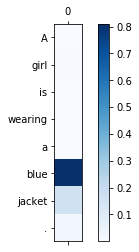

In [28]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

class Batch:
  def __init__(self,prem,hypo):
    self.premise = prem
    self.hypothesis = hypo

def showAttention(input_sentence, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='Blues')
    fig.colorbar(cax)

    # Set up axes
#     ax.set_xticklabels([''] + input_sentence.split(' ') +
#                        ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'])

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    
    
def evaluateAndShowAttention(premise,hypothesis):
  prem = []
  for word in premise.split(' '):
    prem.append(inputs.vocab.stoi[word])
  prem = torch.LongTensor(prem).unsqueeze(1)
  
  hypo = []
  for word in hypothesis.split(' '):
    hypo.append(inputs.vocab.stoi[word])
  hypo = torch.LongTensor(hypo).unsqueeze(1)
#   print(prem.shape,hypo.shape)
  
#   print(hypothesis)
  batch = Batch(prem.cuda(),hypo.cuda())
#   print(batch.hypothesis.shape)
  
  answer,attentions = model(batch)
#   print(attentions.shape)
#   print(premise,attentions[0].detach().cpu().shape)
  print(hypothesis)
  showAttention(premise, attentions[0].detach().cpu())



model.eval()
# premise = 'A boy rides on a camel while talking on his cellphone.' #in a crowded area
# hypothesis = 'A boy is riding an animal.'

premise = 'A girl is wearing a blue jacket .'
hypothesis = 'The jacket is blue .'

# premise = 'A girl is wearing a blue jacket.'
# hypothesis = 'The jacket is pink.'

# premise = 'Our close neighbour .'
# hypothesis = 'Our far distant neighbor .'


evaluateAndShowAttention(premise,hypothesis)